In [1]:
import requests
import pandas as pd
# import pandas_profiling
import numpy as np
from matplotlib import gridspec
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
def download_file(url, filename):
    """
    Helper method handling downloading large files from `url` to `filename`. Returns a pointer to `filename`.
    """
    r = requests.get(url, stream=True)
    with open(filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
    return filename

In [25]:
dat = download_file("https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessType=DOWNLOAD",
                    "NYPD Motor Vehicle Collisions.csv")
dat_df = pd.read_csv(dat, index_col=23)
pd.set_option('display.max_columns', None)

In [24]:
df_100 = dat_df.sample(100)
df_1000 = dat_df.sample(1000)

In [6]:
# df_100 = pd.read_csv("100 point sample.csv")

In [26]:
def missingno(df, figsize=(20, 10), width_ratios=(15, 1), color=(0.25, 0.25, 0.25), fontsize=16):
    # The height and width parameters are the number of rows and the number of columns in the dataframe, respectively.
    height = df.shape[0]
    width = df.shape[1]
    # Z is the color-mask array.
    Z = df.isnull().values

    # G is a NxNx3 matrix
    G = np.zeros((height, width, 3))

    # Apply the Z color-mask to set the RGB of each pixel.
    G[Z > 0.5] = [1, 1, 1]
    G[Z < 0.5] = color

    # Set up the matplotlib grid layout.
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(1, 2, width_ratios=width_ratios)
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    # Create the nullity plot.
    ax0.imshow(G, interpolation='none')

    # Remove extraneous default visual elements.
    ax0.set_aspect('auto')
    ax0.grid(b=False)
    ax0.xaxis.tick_top()
    ax0.xaxis.set_ticks_position('none')
    ax0.yaxis.set_ticks_position('none')
    # Remove the black border.
    ax0.spines['top'].set_visible(False)
    ax0.spines['right'].set_visible(False)
    ax0.spines['bottom'].set_visible(False)
    ax0.spines['left'].set_visible(False)

    # Set up and rotate the column ticks.
    ha = 'left'
    ax0.set_xticks(list(range(0, width)))  # set tick location
    ax0.set_xticklabels(list(df.columns), rotation=45, ha=ha, fontsize=fontsize)  # rotate the labels with anchoring.

    # Set up the two top-bottom row ticks.
    ax0.set_yticks([0, df.shape[0] - 1])
    ax0.set_yticklabels([1, df.shape[0]], fontsize=fontsize + 4)
    # Create the inter-column vertical grid.
    in_between_point = [x + 0.5 for x in range(0, width - 1)]
    for in_between_point in in_between_point:
        ax0.axvline(in_between_point, linestyle='-', color='white')

    # Calculate row-wise completeness for the sparkline.
    completeness_srs = df.notnull().astype(bool).sum(axis=1)
    x_domain = list(range(0, height))
    y_range = list(completeness_srs.values)
    min_completeness = min(y_range)
    max_completeness = max(y_range)

    # Set up the sparkline.
    ax1.grid(b=False)
    ax1.set_aspect('auto')
    ax1.set_axis_bgcolor((1, 1, 1))
    # Remove the black border.
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)

    # Handle sparkline ticks.
    ax1.set_xticks([min_completeness, max_completeness])
    ax1.xaxis.tick_top()
    ax1.xaxis.set_ticks_position('none')
    ax1.set_xticklabels([min_completeness, max_completeness], fontsize=fontsize)
    ax1.set_yticks([])

    # Plot sparkline---plot is sideways so the x and y axis are reversed.
    ax1.plot(y_range, x_domain, color=color)

    plt.show()

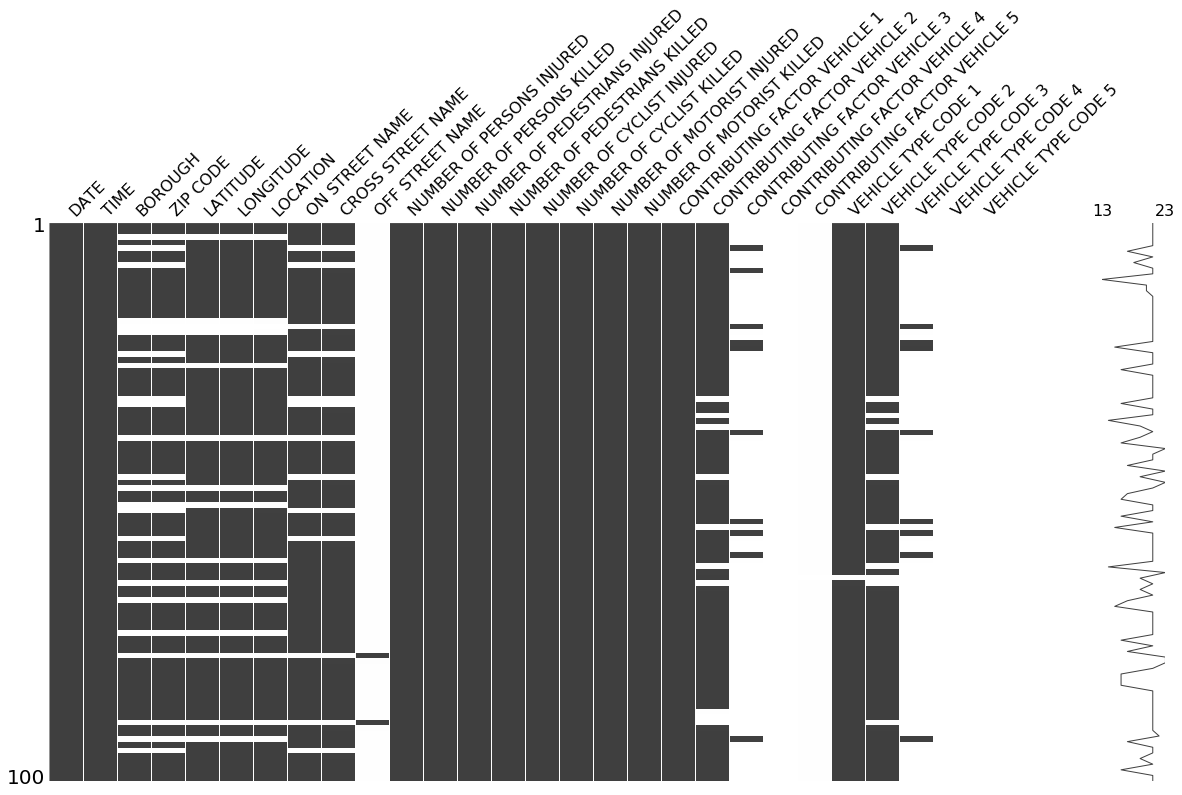

In [27]:
missingno(df_100, color=[0.25, 0.25, 0.25])

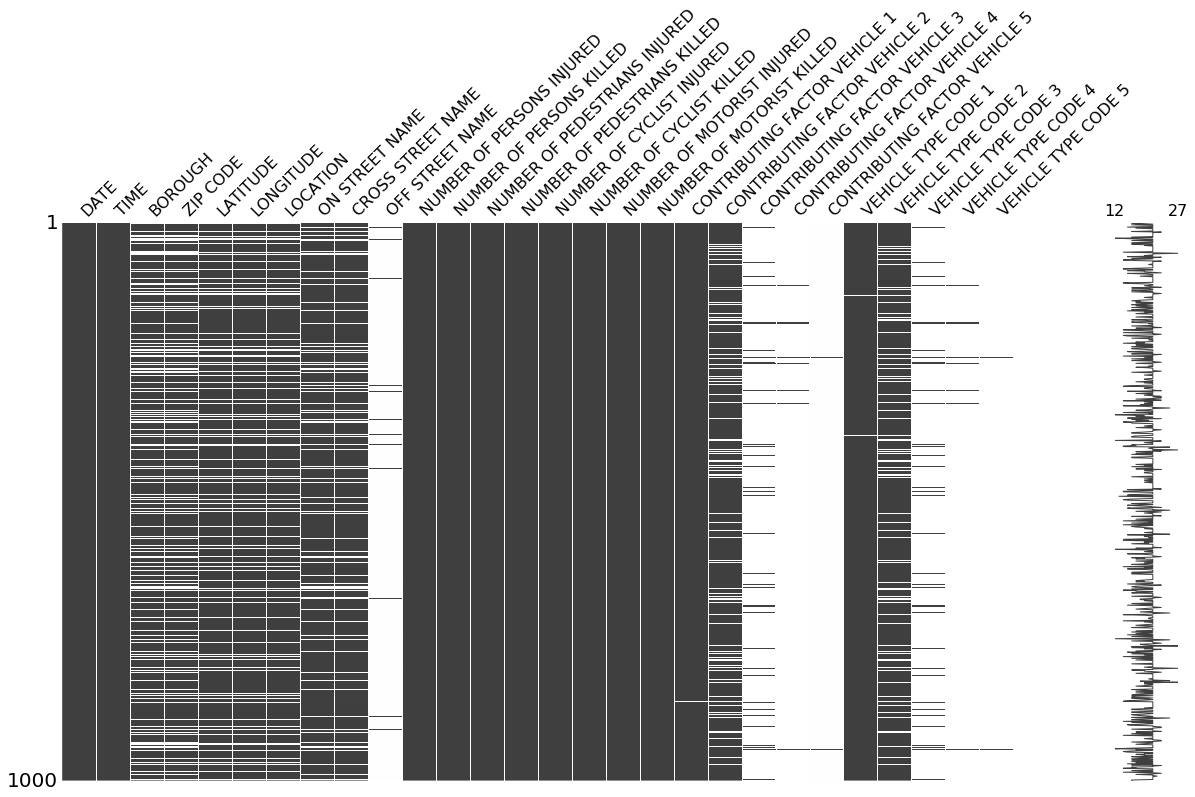

In [28]:
missingno(df_1000)